In [169]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("joniarroba/noshowappointments")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\dima\.cache\kagglehub\datasets\joniarroba\noshowappointments\versions\5


ph - уровень кислотности или щелочности воды<br>
Hardness - cодержание минералов, в основном кальция и магния, в воде<br>
Solids - общее количество растворенных твердых веществ<br>
Chloramines  - хлорамины<br>
Sulfate - сульфаты<br>
Conductivity - электропроводность<br>
Organic_carbon - органический углерод<br>
Trihalomethanes - трихлорметаны<br>
Turbidity - мутность<br>
Potability - пригодность для питья<br>
0 - непригодна 1-пригодна

In [175]:
import pandas as pd
import numpy as np
import pickle

from torch.autograd import Variable
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader


import torch.utils.data as data_utils
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams

from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42
LABELS = ["Не появился", "Появился"]

In [191]:
df = pd.read_csv("C:\\Users\\dima\\.cache\\kagglehub\\datasets\\joniarroba\\noshowappointments\\versions\\5\\KaggleV2-May-2016.csv")

In [192]:
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [ ]:
'''df['AppointmentDay'] = pd.to_datetime(df['AppointmentDay'], errors='coerce')
df['ScheduledDay'] = pd.to_datetime(df['ScheduledDay'], errors='coerce')

# Удаление строк с пропущенными значениями
df = df.dropna(subset=['AppointmentDay', 'ScheduledDay'])

# Разделение на отдельные столбцы
df['Appoi_year'] = df['AppointmentDay'].dt.year
df['Appoi_month'] = df['AppointmentDay'].dt.month
df['Appoi_day'] = df['AppointmentDay'].dt.day
df['Appoi_hour'] = df['AppointmentDay'].dt.hour
df['Appoi_minute'] = df['AppointmentDay'].dt.minute
df['Appoi_group_interval'] = (df['Appoi_hour'] * 60 + df['Appoi_minute']) // 30 + 1
df = df.drop(columns='AppointmentDay')

df['Scheduled_year'] = df['ScheduledDay'].dt.year
df['Scheduled_month'] = df['ScheduledDay'].dt.month
df['Scheduled_day'] = df['ScheduledDay'].dt.day
df['Scheduled_hour'] = df['ScheduledDay'].dt.hour
df['Scheduled_minute'] = df['ScheduledDay'].dt.minute
df['Scheduled_group_interval'] = (df['Scheduled_hour'] * 60 + df['Scheduled_minute']) // 30 + 1
df = df.drop(columns='ScheduledDay')

# Перемещение столбца 'No-show' в конец
df = df[[col for col in df.columns if col != 'No-show'] + ['No-show']]'''

In [193]:
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()
df[['Neighbourhood','AppointmentDay' ,'ScheduledDay','AppointmentID', 'Gender', 'No-show']] = enc.fit_transform(df[['Neighbourhood','AppointmentDay','ScheduledDay' ,'AppointmentID', 'Gender', 'No-show']])
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,29332.0,0.0,27741.0,0.0,62,39.0,0,1,0,0,0,0,0.0
1,5.589978e+14,29079.0,1.0,27503.0,0.0,56,39.0,0,0,0,0,0,0,0.0
2,4.262962e+12,29115.0,0.0,27538.0,0.0,62,45.0,0,0,0,0,0,0,0.0
3,8.679512e+11,29299.0,0.0,27708.0,0.0,8,54.0,0,0,0,0,0,0,0.0
4,8.841186e+12,29073.0,0.0,27497.0,0.0,56,39.0,0,1,1,0,0,0,0.0


In [194]:
df.shape

(110527, 14)

In [195]:
df = df.fillna(df.median())

In [196]:
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,29332.0,0.0,27741.0,0.0,62,39.0,0,1,0,0,0,0,0.0
1,5.589978e+14,29079.0,1.0,27503.0,0.0,56,39.0,0,0,0,0,0,0,0.0
2,4.262962e+12,29115.0,0.0,27538.0,0.0,62,45.0,0,0,0,0,0,0,0.0
3,8.679512e+11,29299.0,0.0,27708.0,0.0,8,54.0,0,0,0,0,0,0,0.0
4,8.841186e+12,29073.0,0.0,27497.0,0.0,56,39.0,0,1,1,0,0,0,0.0


In [197]:
df['No-show'].value_counts()

No-show
0.0    88208
1.0    22319
Name: count, dtype: int64

C:\Users\dima\AppData\Local\Temp\ipykernel_17884\197740428.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  count_classes = pd.value_counts(df['No-show'], sort = True)


Text(0, 0.5, 'Частота')

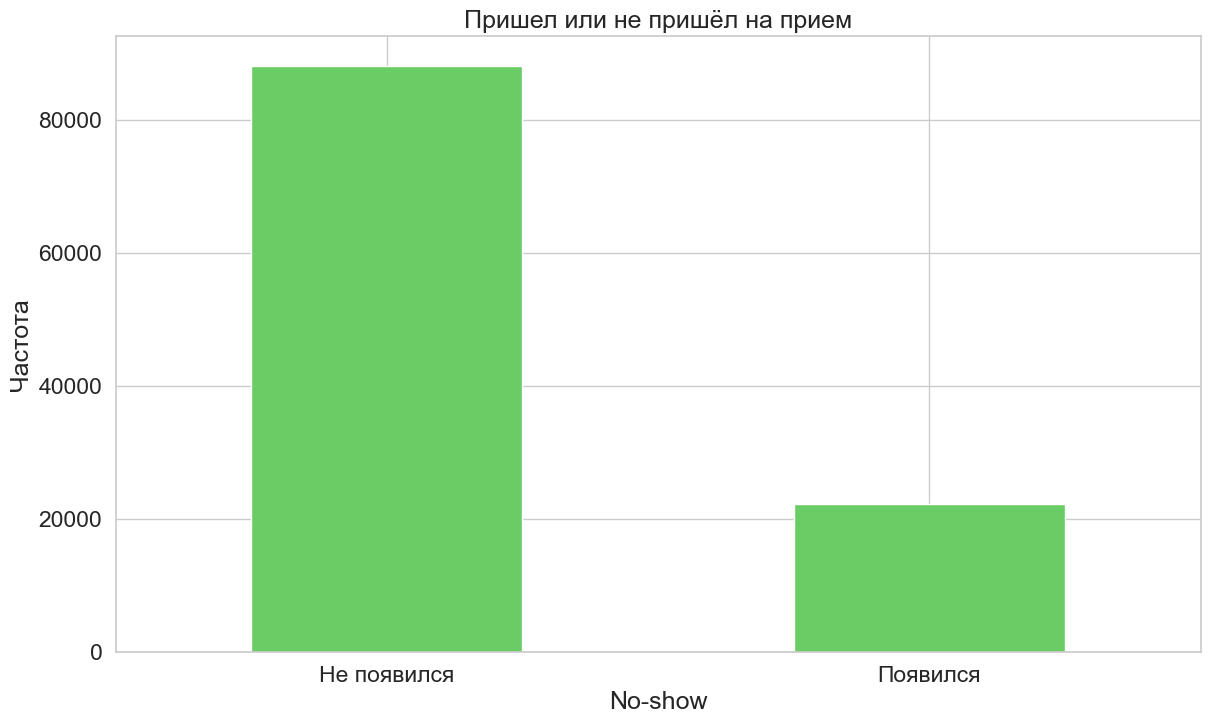

In [198]:
count_classes = pd.value_counts(df['No-show'], sort = True)
count_classes.plot(kind = 'bar', rot=0, color="g")
plt.title("Пришел или не пришёл на прием")
plt.xticks(range(2), LABELS)
plt.ylabel("Частота")

<Axes: >

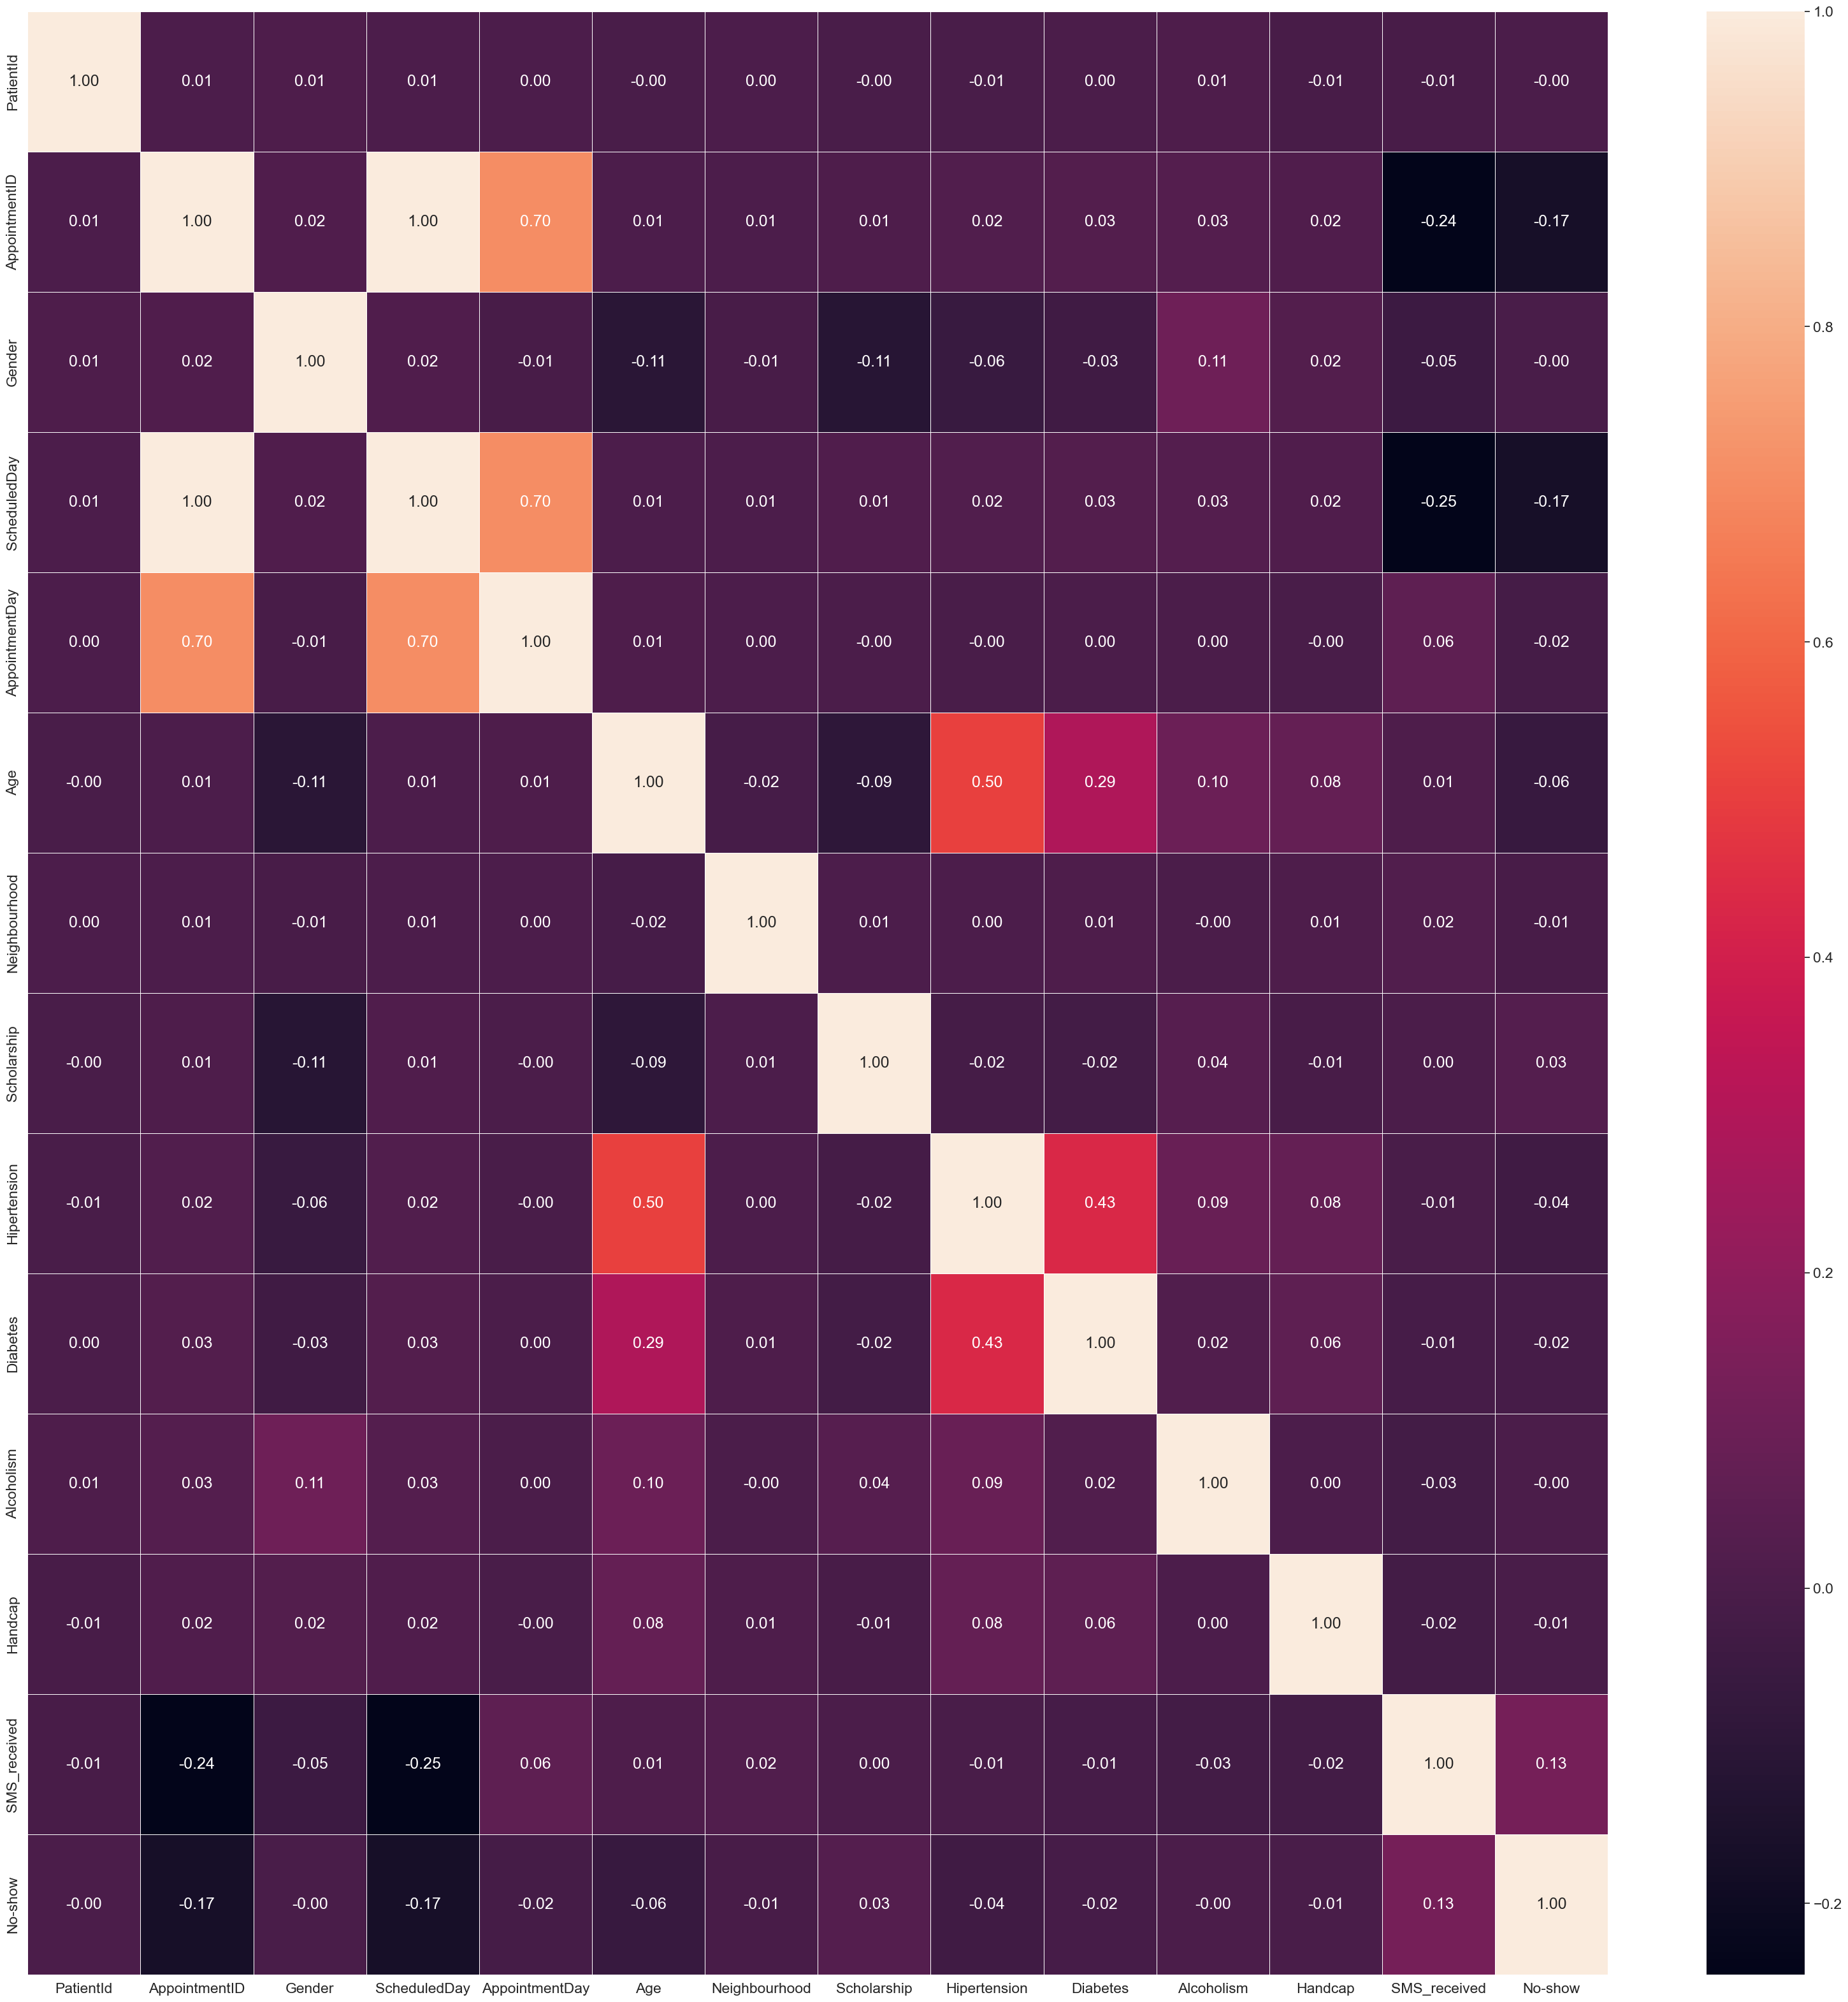

In [199]:
import matplotlib.pyplot as plt
import seaborn as sns
corr = df.corr()

plt.figure(figsize=(40,40))
sns.heatmap(corr, annot=True, fmt=".2f", linewidths=0.5)

In [ ]:
df = df.drop(columns='Appoi_year')
df = df.drop(columns='Appoi_hour')
df = df.drop(columns='Appoi_minute')
df = df.drop(columns='Appoi_group_interval')

In [200]:
df.shape

(110527, 14)

In [201]:
df = df.rename(columns={'No-show': 'Visit'})
X_train, X_test = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED)
X_train = X_train[X_train.Visit == 0]
X_train = X_train.drop(['Visit'], axis=1)
y_test = X_test['Visit']
X_test = X_test.drop(['Visit'], axis=1)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = torch.tensor(X_train, dtype=torch.float64)
X_test = torch.tensor(X_test, dtype=torch.float64)
y_test = torch.tensor(y_test.values, dtype=torch.float64)

In [209]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
        nn.Linear(13, 10),
        nn.Tanh(),
        nn.Linear(10, 7),
        nn.LeakyReLU(),
        nn.Linear(7, 4),
        nn.LeakyReLU()
        )

        self.decoder = nn.Sequential(
            nn.Linear(4, 7),
            nn.Tanh(),
            nn.Linear(7, 10),
            nn.LeakyReLU(),
            nn.Linear(10, 13),
            nn.LeakyReLU()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [210]:
model = Autoencoder().double().cpu()

In [211]:
num_epochs = 100
minibatch_size = 32
learning_rate = 1e-4

In [212]:

train_loader = data_utils.DataLoader(X_train, batch_size=minibatch_size, shuffle=True)
test_loader = data_utils.DataLoader(X_test, batch_size=1, shuffle=False)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
model.parameters(), lr=learning_rate, weight_decay=10e-05)
history = {}
history['train_loss'] = []
history['test_loss'] = []


In [213]:

for epoch in range(num_epochs):
    h = np.array([])
    for data in train_loader:
        #print(type(data))
        #data = Variable(data).cpu()
        #print(type(data))
        # ===================forward=====================
        output = model(data)
        loss = criterion(output, data)
        h = np.append(h, loss.item())

        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    mean_loss = np.mean(h)
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch + 1, num_epochs, mean_loss))
    history['train_loss'].append(mean_loss)


torch.save(model.state_dict(), './heart_attack_model.pth')

epoch [1/100], loss:0.9576
epoch [2/100], loss:0.8304
epoch [3/100], loss:0.7584
epoch [4/100], loss:0.7051
epoch [5/100], loss:0.6866
epoch [6/100], loss:0.6746
epoch [7/100], loss:0.6616
epoch [8/100], loss:0.6457
epoch [9/100], loss:0.6310
epoch [10/100], loss:0.6212
epoch [11/100], loss:0.6153
epoch [12/100], loss:0.6110
epoch [13/100], loss:0.6072
epoch [14/100], loss:0.6035
epoch [15/100], loss:0.6001
epoch [16/100], loss:0.5966
epoch [17/100], loss:0.5929
epoch [18/100], loss:0.5892
epoch [19/100], loss:0.5847
epoch [20/100], loss:0.5791
epoch [21/100], loss:0.5726
epoch [22/100], loss:0.5663
epoch [23/100], loss:0.5608
epoch [24/100], loss:0.5562
epoch [25/100], loss:0.5529
epoch [26/100], loss:0.5506
epoch [27/100], loss:0.5486
epoch [28/100], loss:0.5471
epoch [29/100], loss:0.5459
epoch [30/100], loss:0.5446
epoch [31/100], loss:0.5434
epoch [32/100], loss:0.5424
epoch [33/100], loss:0.5411
epoch [34/100], loss:0.5398
epoch [35/100], loss:0.5385
epoch [36/100], loss:0.5370
e

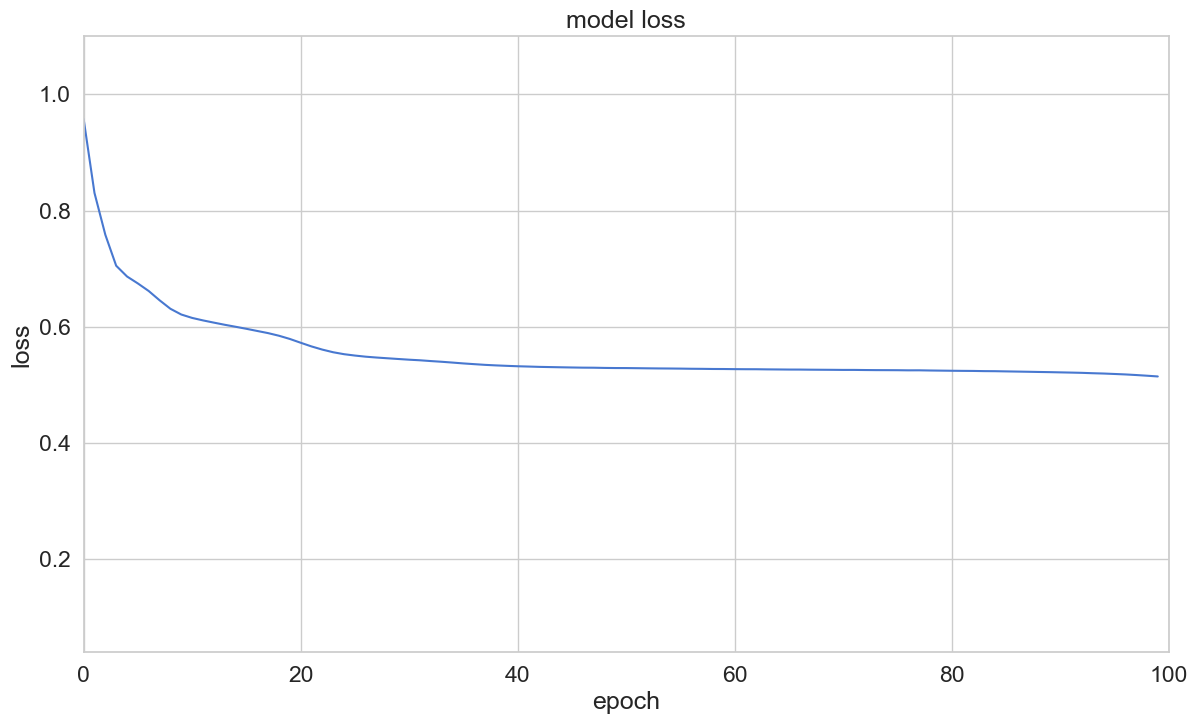

In [215]:

#history['train_loss']
#plt.plot(range(num_epochs),history['train_loss'],'ro',linewidth=2.0)
plt.plot(history['train_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.axis([0,100,0.04,1.1])
#plt.legend(['train', 'test'], loc='upper right');
plt.show()

In [216]:
pred_losses = {'pred_loss' : []}
model.eval()
with torch.no_grad():
   # test_loss = 0
    for data in test_loader:
        inputs = data
        # print(inputs)
        outputs = model(inputs)
        loss = criterion(outputs, inputs).data.item()
        #print(loss)
        pred_losses['pred_loss'].append(loss)
        #pred_losses = model([y_test.size, y_test])
reconstructionErrorDF = pd.DataFrame(pred_losses)
reconstructionErrorDF['Visit'] = y_test

In [217]:
reconstructionErrorDF.describe()

,pred_loss,Visit
count,22106.000000,22106.000000
mean,0.518143,0.200715
std,0.732457,0.400544
min,0.012816,0.000000
25%,0.211092,0.000000
50%,0.354886,0.000000
75%,0.584352,0.000000
max,26.279385,1.000000


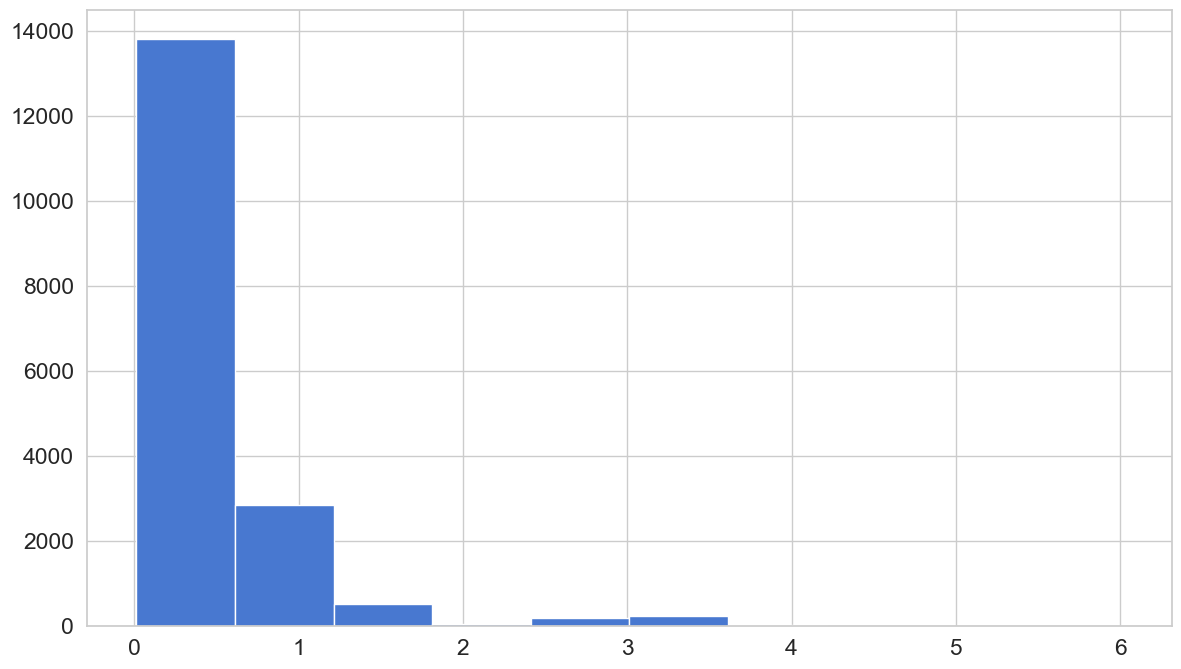

In [219]:
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = reconstructionErrorDF[(reconstructionErrorDF['Visit']== 0) & (reconstructionErrorDF['pred_loss'] < 10)]
_ = ax.hist(normal_error_df.pred_loss.values, bins=10)

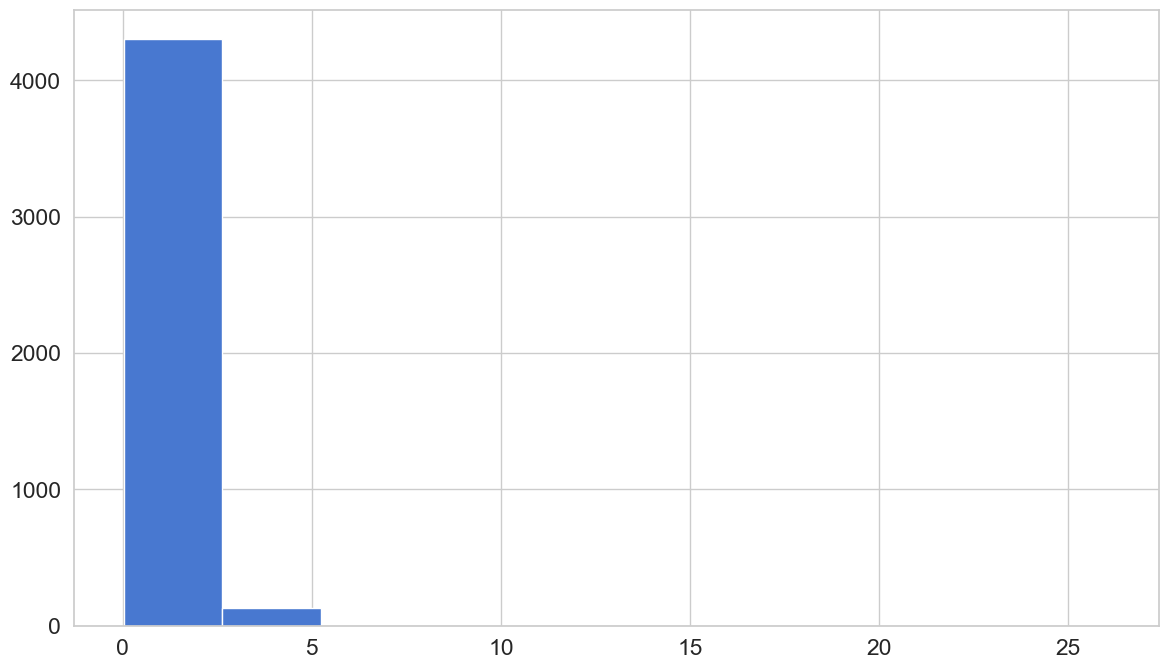

In [220]:
fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = reconstructionErrorDF[(reconstructionErrorDF['Visit']== 1) ]
_ = ax.hist(fraud_error_df.pred_loss.values, bins=10)

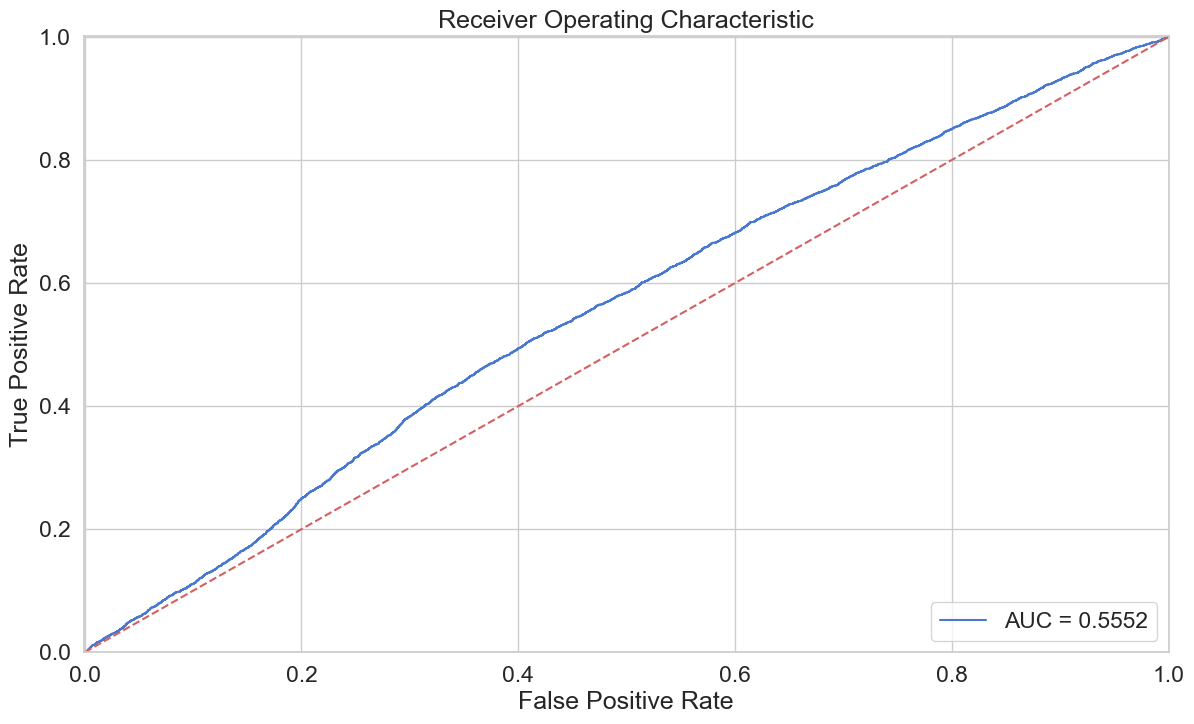

In [221]:
fpr, tpr, thresholds = roc_curve(reconstructionErrorDF.Visit, reconstructionErrorDF.pred_loss)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

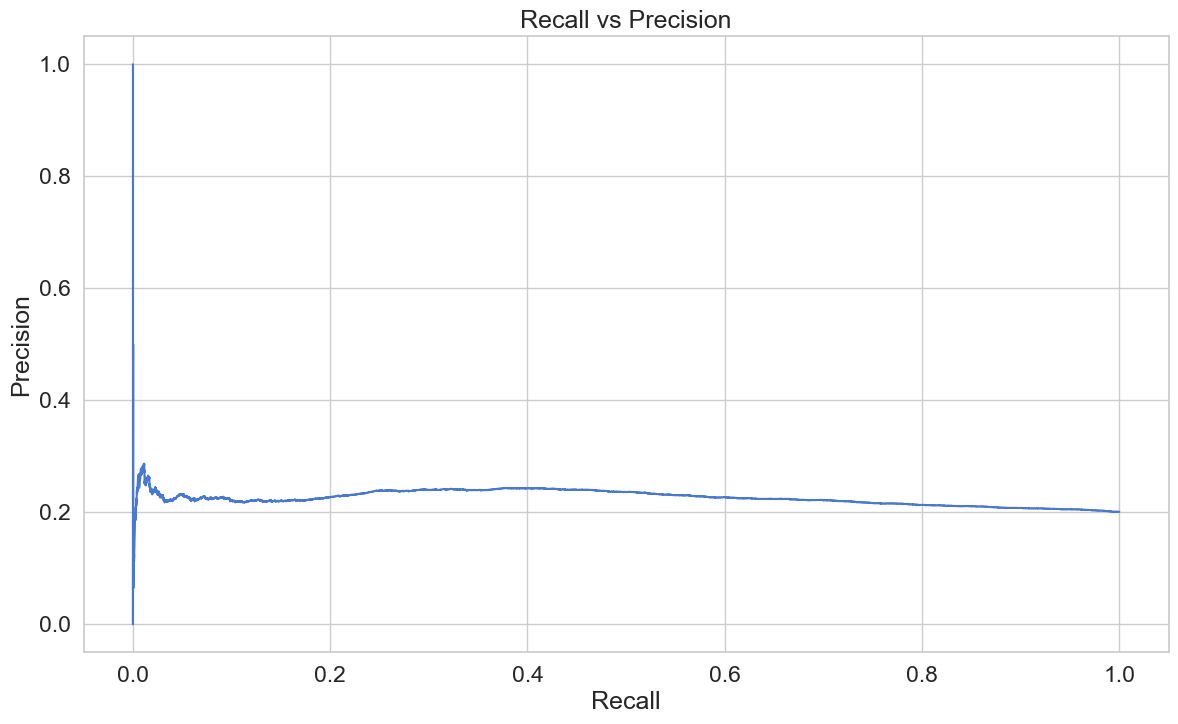

In [222]:
precision, recall, th = precision_recall_curve(reconstructionErrorDF.Visit, reconstructionErrorDF.pred_loss)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

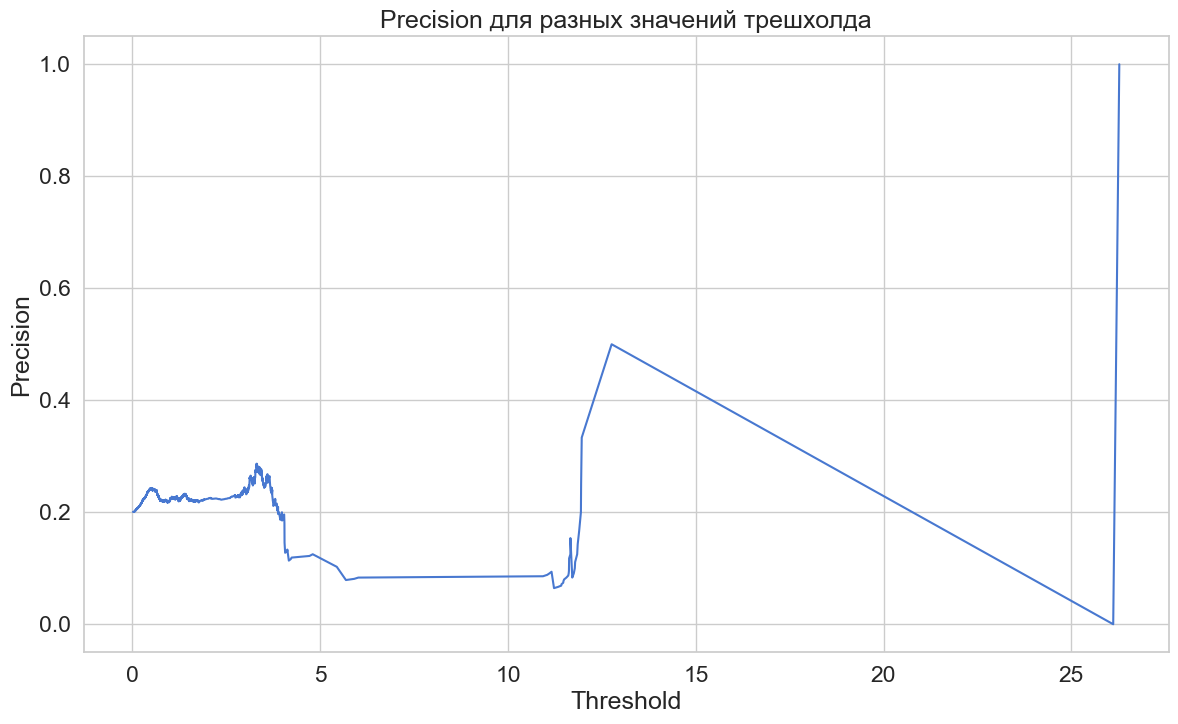

In [223]:
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision для разных значений трешхолда')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

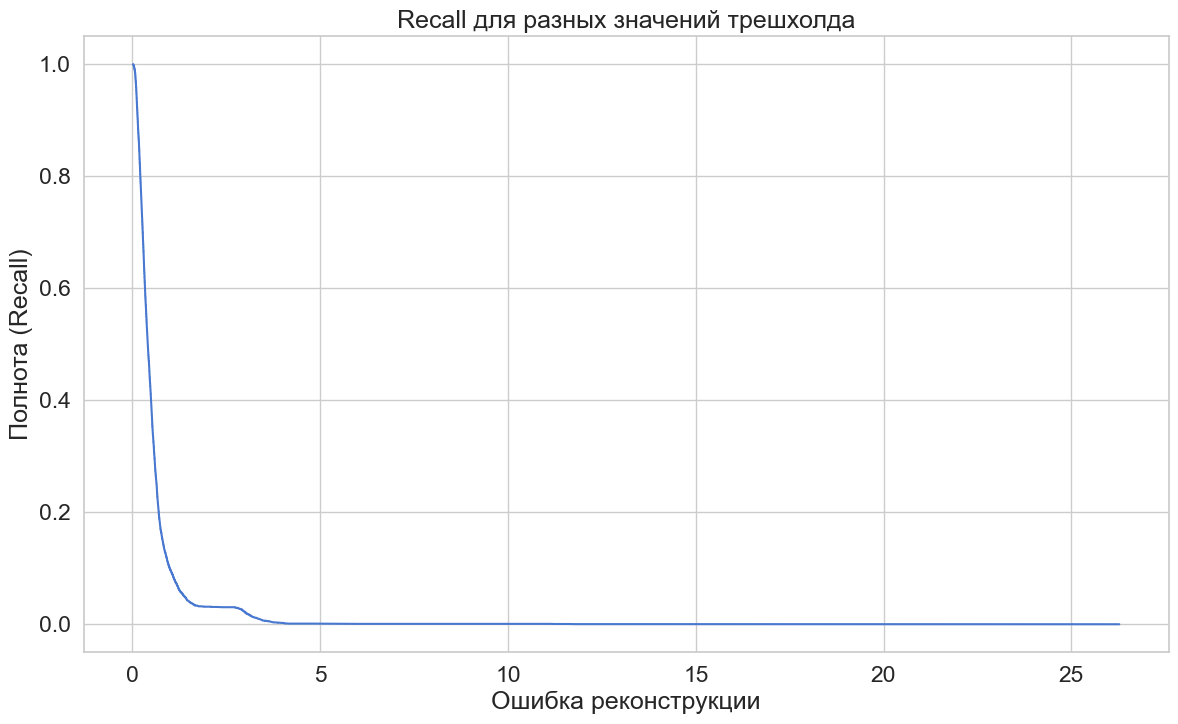

In [224]:
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall для разных значений трешхолда')
plt.xlabel('Ошибка реконструкции')
plt.ylabel('Полнота (Recall)')
plt.show()

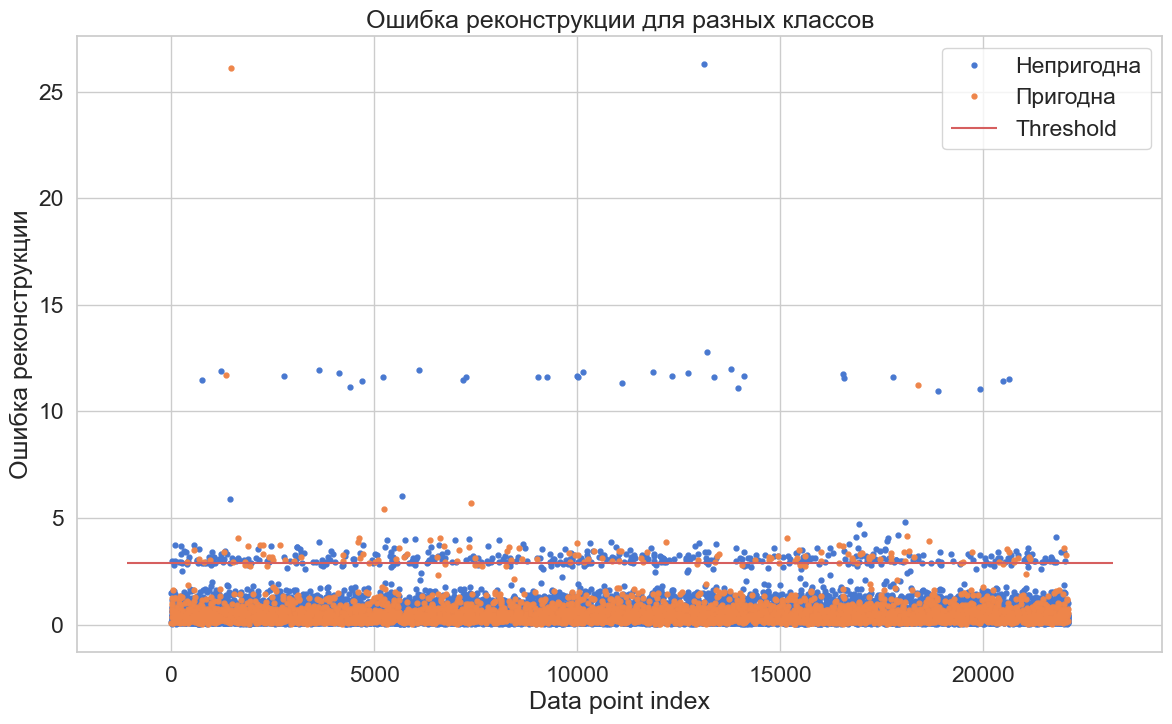

In [225]:
threshold = 2.9
groups = reconstructionErrorDF.groupby('Visit')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.pred_loss, marker='o', ms=3.5, linestyle='',
            label= "Пригодна" if name == 1 else "Непригодна")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Ошибка реконструкции для разных классов")
plt.ylabel("Ошибка реконструкции")
plt.xlabel("Data point index")
plt.show();

C:\Users\dima\AppData\Local\Temp\ipykernel_17884\4142777068.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap=plt.cm.get_cmap('Blues'));


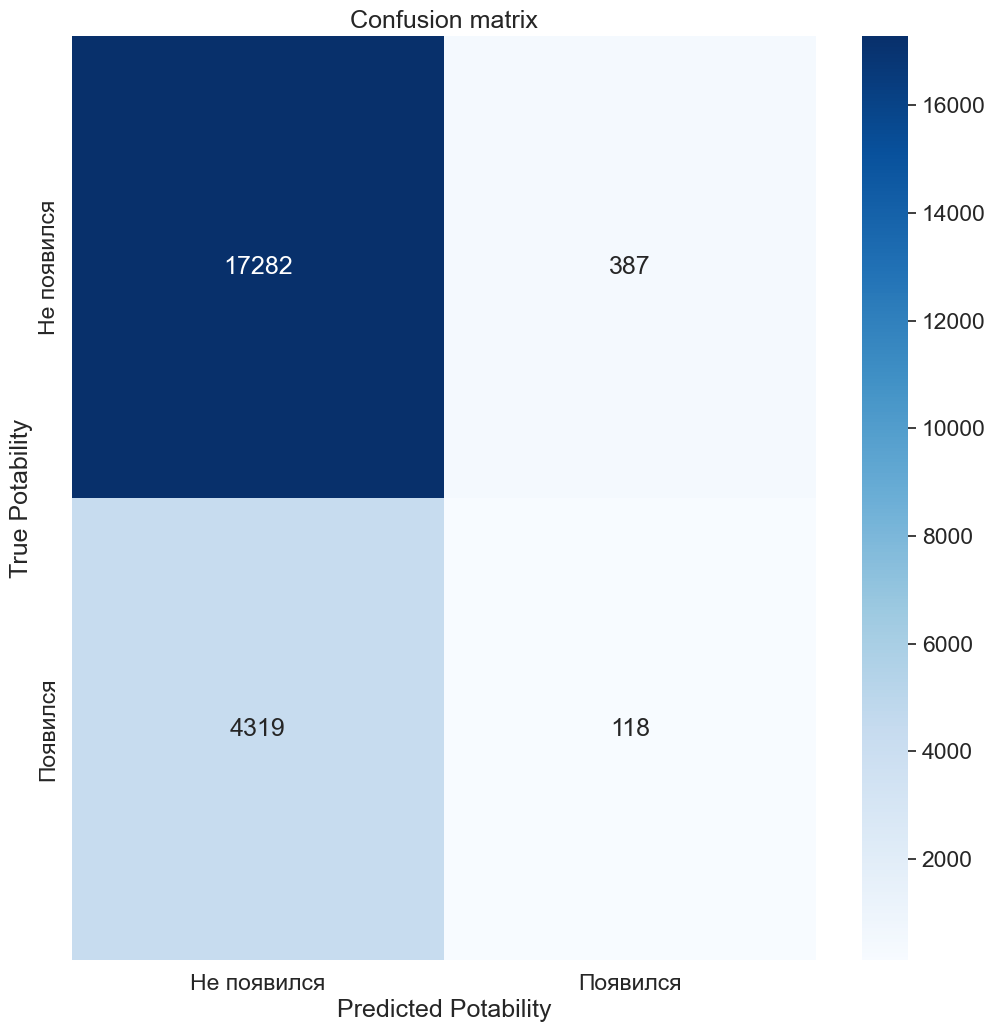

In [226]:

y_pred = [1 if e > threshold else 0 for e in reconstructionErrorDF.pred_loss.values]
conf_matrix = confusion_matrix(reconstructionErrorDF.Visit, y_pred)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d",
            cmap=plt.cm.get_cmap('Blues'));
plt.title("Confusion matrix")
plt.ylabel('True Potability')
plt.xlabel('Predicted Potability')
plt.show()